In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
df = pd.read_csv("/content/drive/MyDrive/DataMining_FinalProject/spotify_millsongdata.csv")
#df = pd.read_csv("spotify_millsongdata.csv")
df.head()

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \r\nA..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \r\nTouch me gen..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \r\nWhy I had...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...


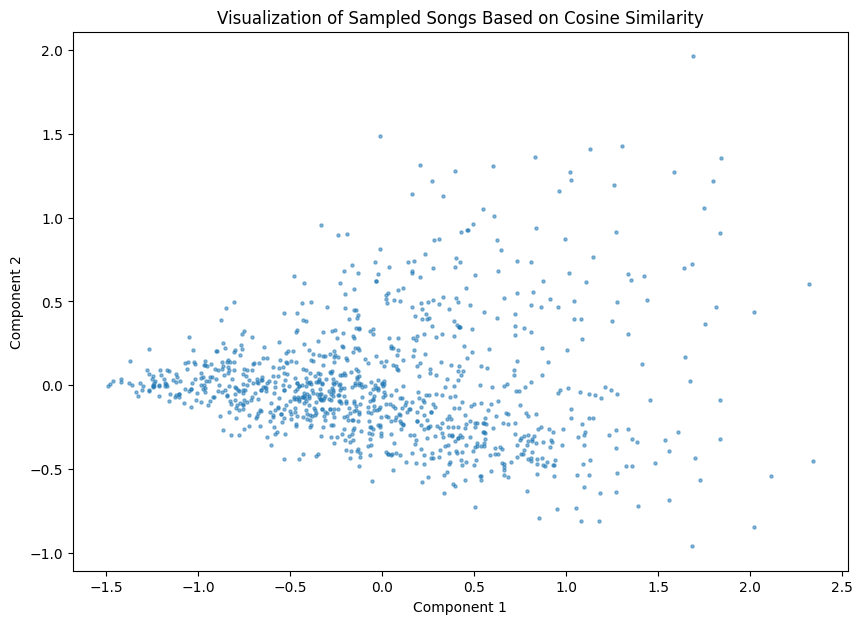

In [3]:
#Sample data Cosine similarity visualization
#Reduce data for faster run time
sampled_data = df.sample(n=1000, random_state=42)

# Convert text to numerical representation using TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
sampled_tfidf_matrix = tfidf_vectorizer.fit_transform(sampled_data['text'])

# Compute cosine similarity
sampled_cosine_sim_matrix = cosine_similarity(sampled_tfidf_matrix)


pca = PCA(n_components=2)
sampled_pca_result = pca.fit_transform(sampled_cosine_sim_matrix)

plt.figure(figsize=(10, 7))
plt.scatter(sampled_pca_result[:, 0], sampled_pca_result[:, 1], alpha=0.5, s=5)
plt.title("Visualization of Sampled Songs Based on Cosine Similarity")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()


Pre-Processing: Checking for null or duplicate values

In [4]:
#Check null values
df.isna().sum()

,0
artist,0
song,0
link,0
text,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57650 entries, 0 to 57649
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   artist  57650 non-null  object
 1   song    57650 non-null  object
 2   link    57650 non-null  object
 3   text    57650 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


In [6]:
#Check data types
df.dtypes

,0
artist,object
song,object
link,object
text,object


In [7]:
#Drop Link since it is not necessary for the reccomender system
df.drop("link", axis=1, inplace = True)
df.head()

,artist,song,text
0,ABBA,Ahe's My Kind Of Girl,"Look at her face, it's a wonderful face \r\nA..."
1,ABBA,"Andante, Andante","Take it easy with me, please \r\nTouch me gen..."
2,ABBA,As Good As New,I'll never know why I had to go \r\nWhy I had...
3,ABBA,Bang,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,Making somebody happy is a question of give an...


In [9]:
df.duplicated().sum()

0

Modeling

In [10]:
df = df[0:20000] # Only using the first 20000 values in the dataset, as the runtime is too long when using more values
df['Combined_features'] = df['artist'] + " " + df['song'] + " " + df['text'] # Combining artist name, song name, and lyrics as a new feature to make it easier to recommend songs
import re
import nltk
from nltk.corpus import stopwords
def cleaning(text):
    # Cleaning the text (setting the lyrics to lowercase and splitting them into an array so that it's easier to match the test value with the lyrics)
    text = re.sub("[^a-zA-Z]", " ", text)
    text = text.lower()
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text
#Apply the cleaning function to the 'combined_features' column


In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

def vectorize_features(df, column, max_features=2000):
    tfv = TfidfVectorizer(max_features=max_features)
    return tfv.fit_transform(df[column])

def compute_similarity(df):
    tfv_matrix = vectorize_features(df, "Combined_features")
    return cosine_similarity(tfv_matrix)

def recommended_songs(song_user_likes, df, cosine_sim):
    if song_user_likes not in df['song'].values:
        print(f"'{song_user_likes}' not found in the dataset.")
        return

    song_index = df[df['song'] == song_user_likes].index[0] # finds the index of the song that matches the value entered
    similar_songs = list(enumerate(cosine_sim[song_index])) # using cosine similarity in the combined features to add the similar songs to the list
    similar_song_sorted = sorted(similar_songs, key=lambda x: x[1], reverse=True) # sorts the list of songs by similarity

    # Print the list of songs
    print(f"Recommendations based on '{song_user_likes}':\n")
    for song in similar_song_sorted[1:11]:
        similar_song_name = df.iloc[song[0]]["song"]
        similar_artist_name = df.iloc[song[0]]["artist"]
        print(f"{similar_song_name} by {similar_artist_name}")

cosine_sim = compute_similarity(df)
user_entered = input("Enter a song you like: ")
#Test
recommended_songs(user_entered, df, cosine_sim)

Enter a song you like: Bang
Recommendations based on 'Bang':

Sea Of Dreams by Electric Light Orchestra
Dum Dum by Lana Del Rey
The Prime Of Your Love by Billy Joel
Afterparty by Rihanna
Bloody Mary by Lady Gaga
Bang-A-Boomerang by ABBA
Janie's Got A Gun by Aerosmith
Endless Love by Diana Ross
Disturbia by Rihanna
Beautiful Doom by Insane Clown Posse


In [ ]:
def vectorize_features(df, column, max_features=2000):
    tfv = TfidfVectorizer(max_features=max_features)
    return tfv.fit_transform(df[column])

def compute_similarity(df):
    tfv_matrix = vectorize_features(df, "Combined_features")
    return cosine_similarity(tfv_matrix)

def recommended_songs(song_user_likes, df, cosine_sim):
    if song_user_likes not in df['song'].values:
        print(f"'{song_user_likes}' not found in the dataset.")
        return

    song_index = df[df['song'] == song_user_likes].index[0] # finds the index of the song that matches the value entered
    similar_songs = list(enumerate(cosine_sim[song_index])) # using cosine similarity in the combined features to add the similar songs to the list
    similar_song_sorted = sorted(similar_songs, key=lambda x: x[1], reverse=True) # sorts the list of songs by similarity

    # Print the list of songs
    print(f"Recommendations based on '{song_user_likes}':\n")
    for song in similar_song_sorted[1:11]:
        similar_song_name = df.iloc[song[0]]["song"]
        similar_artist_name = df.iloc[song[0]]["artist"]
        print(f"{similar_song_name} by {similar_artist_name}")

cosine_sim = compute_similarity(df)
user_entered = input("Enter a song you like: ")
#Test
recommended_songs(user_entered, df, cosine_sim)

Enter a song you like: Love
Recommendations based on 'Love':

It's So Cool by Madonna
You Wrote The Book On Love by Backstreet Boys
Love To Love by Ufo
Love For Sale by Cole Porter
Love To Love You Baby by Donna Summer
All Love by Ingrid Michaelson
I Do Love You by Beach Boys
Mystery Of Love by Donna Summer
Love For Sale by Boney M.
Because It's Really Love by Luther Vandross


In [ ]:
def vectorize_features(df, column, max_features=2000):
    tfv = TfidfVectorizer(max_features=max_features)
    return tfv.fit_transform(df[column])

def compute_similarity(df):
    tfv_matrix = vectorize_features(df, "Combined_features")
    return cosine_similarity(tfv_matrix)

def recommended_songs(song_user_likes, df, cosine_sim):
    if song_user_likes not in df['song'].values:
        print(f"'{song_user_likes}' not found in the dataset.")
        return

    song_index = df[df['song'] == song_user_likes].index[0] # finds the index of the song that matches the value entered
    similar_songs = list(enumerate(cosine_sim[song_index])) # using cosine similarity in the combined features to add the similar songs to the list
    similar_song_sorted = sorted(similar_songs, key=lambda x: x[1], reverse=True) # sorts the list of songs by similarity

    # Print the list of songs
    print(f"Recommendations based on '{song_user_likes}':\n")
    for song in similar_song_sorted[1:11]:
        similar_song_name = df.iloc[song[0]]["song"]
        similar_artist_name = df.iloc[song[0]]["artist"]
        print(f"{similar_song_name} by {similar_artist_name}")

cosine_sim = compute_similarity(df)
user_entered = input("Enter a song you like: ")
#Test
recommended_songs(user_entered, df, cosine_sim)

Enter a song you like: Life
Recommendations based on 'Life':

Does Anybody Out There Even Care by Lenny Kravitz
Breakaway by Donna Summer
Anybody Seen My Baby? by Rolling Stones
How Many Times by Toto
Why Is Everybody Going Home by Leo Sayer
Survivor by Michael Bolton
Rock Show by Lady Gaga
Get It Right by Out Of Eden
End Of All Time by Gordon Lightfoot
Too Many Times by Michael W. Smith


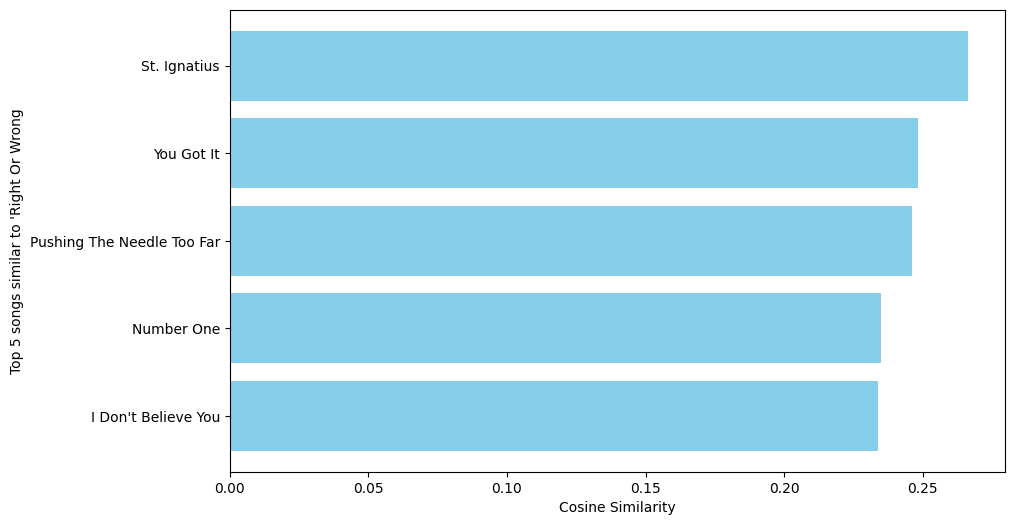

In [ ]:
song_index = 0
similarities = sampled_cosine_sim_matrix[song_index]
similar_song_indices = np.argsort(similarities)[-6:-1][::-1] # Changed np.arg.argsort to np.argsort

#Plot similarities
plt.figure(figsize=(10, 6))
plt.barh(
sampled_data.iloc[similar_song_indices]['song'],
similarities[similar_song_indices],
color='skyblue'
)
plt.xlabel('Cosine Similarity')
plt.ylabel(f"Top 5 songs similar to '{sampled_data.iloc[song_index]['song']}")
plt.gca().invert_yaxis()
plt.show()

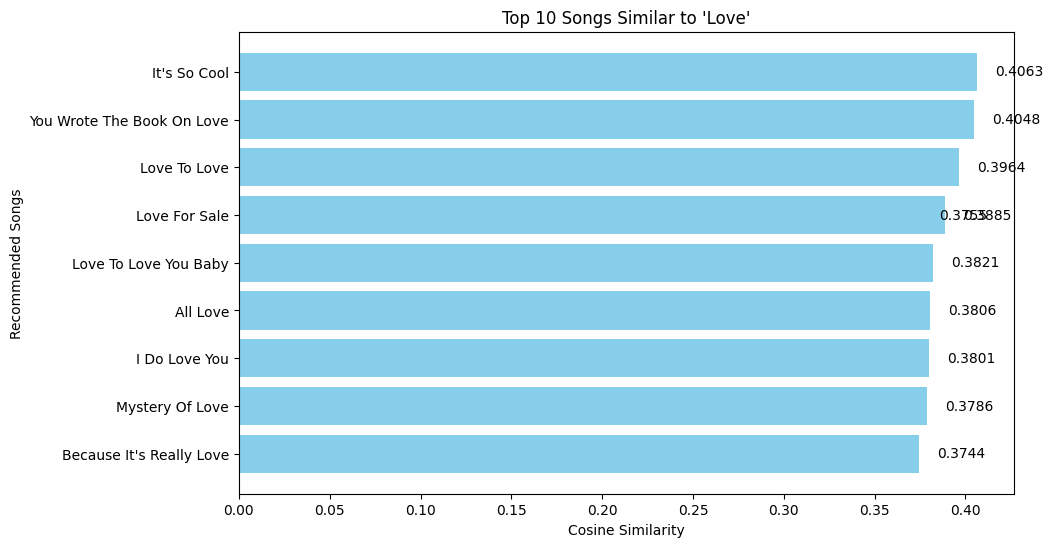

In [ ]:
def visualize_cosine_similarity(song_user_likes, df, cosine_sim, top_k=10):
    if song_user_likes not in df['song'].values:
        print(f"'{song_user_likes}' not found in the dataset.")
        return

    song_index = df[df['song'] == song_user_likes].index[0]

    similarities = cosine_sim[song_index]

    similar_song_indices = np.argsort(similarities)[-top_k-1:-1][::-1]

    song_names = df.iloc[similar_song_indices]['song'].values
    similarity_scores = similarities[similar_song_indices]

    plt.figure(figsize=(10, 6))
    bars = plt.barh(song_names, similarity_scores, color="skyblue")
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Recommended Songs")
    plt.title(f"Top {top_k} Songs Similar to '{song_user_likes}'")
    plt.gca().invert_yaxis()

    for bar, score in zip(bars, similarity_scores):
        plt.text(
            bar.get_width() + 0.01,
            bar.get_y() + bar.get_height() / 2,
            f"{score:.4f}",
            va="center",
            ha="left",
            fontsize=10,
            color="black"
        )

    plt.show()

visualize_cosine_similarity("Love", df, cosine_sim, top_k=10)

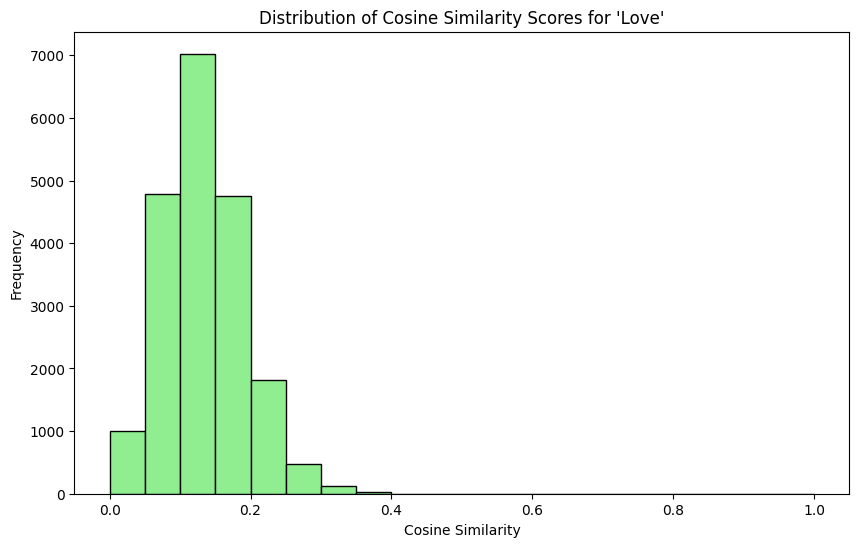

In [ ]:
def plot_similarity_distribution(song_user_likes, df, cosine_sim):
    if song_user_likes not in df['song'].values:
        print(f"'{song_user_likes}' not found in the dataset.")
        return

    song_index = df[df['song'] == song_user_likes].index[0]

    similarities = cosine_sim[song_index]

    plt.figure(figsize=(10, 6))
    plt.hist(similarities, bins=20, color="lightgreen", edgecolor="black")
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Frequency")
    plt.title(f"Distribution of Cosine Similarity Scores for '{song_user_likes}'")
    plt.show()

plot_similarity_distribution("Love", df, cosine_sim)

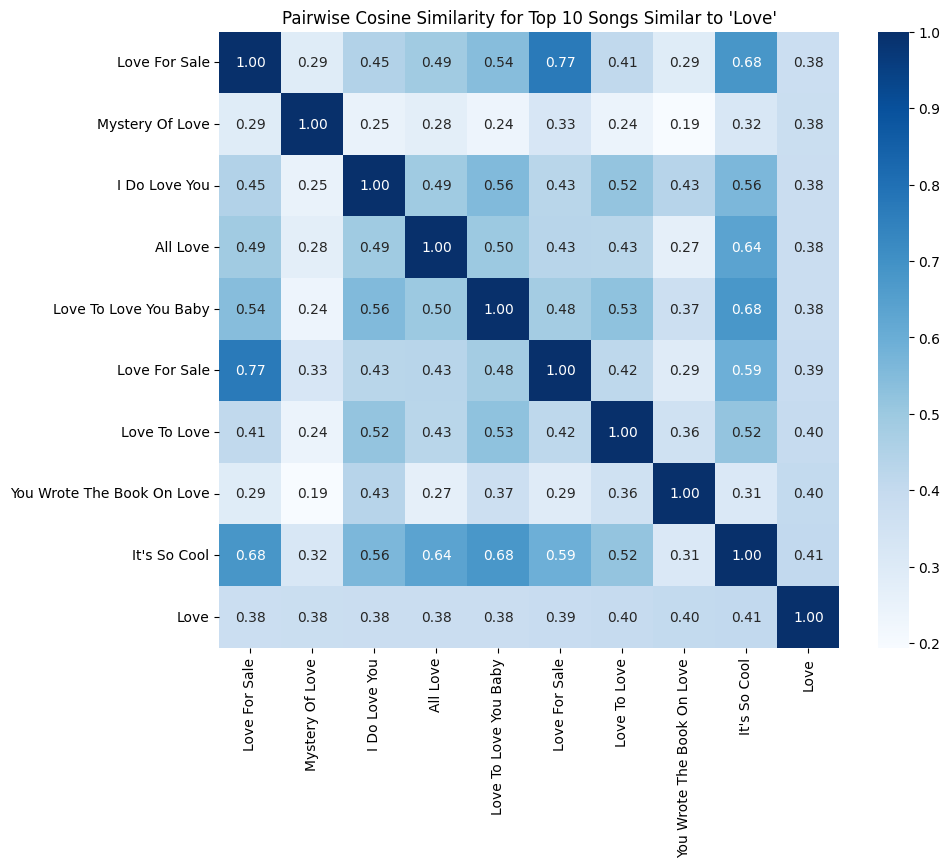

In [ ]:
import seaborn as sns

def plot_similarity_heatmap(song_user_likes, df, cosine_sim, top_k=10):
    if song_user_likes not in df['song'].values:
        print(f"'{song_user_likes}' not found in the dataset.")
        return

    song_index = df[df['song'] == song_user_likes].index[0]

    similarities = cosine_sim[song_index]
    similar_song_indices = np.argsort(similarities)[-top_k:]

    similarity_subset = cosine_sim[np.ix_(similar_song_indices, similar_song_indices)]

    song_names = df.iloc[similar_song_indices]['song'].values

    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_subset, annot=True, fmt=".2f", xticklabels=song_names, yticklabels=song_names, cmap="Blues")
    plt.title(f"Pairwise Cosine Similarity for Top {top_k} Songs Similar to '{song_user_likes}'")
    plt.show()

plot_similarity_heatmap("Love", df, cosine_sim, top_k=10)

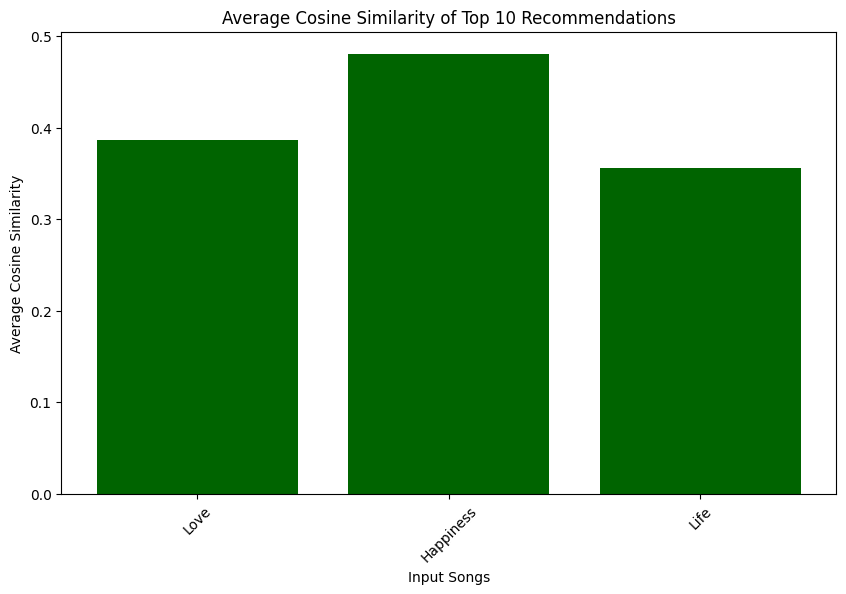

In [ ]:
def average_similarity_across_songs(input_songs, df, cosine_sim, top_k=10):
    avg_similarities = []

    for song_user_likes in input_songs:
        if song_user_likes not in df['song'].values:
            print(f"'{song_user_likes}' not found in the dataset.")
            continue

        song_index = df[df['song'] == song_user_likes].index[0]

        similarities = cosine_sim[song_index]
        similar_song_indices = np.argsort(similarities)[-top_k-1:-1][::-1]
        recommended_similarities = similarities[similar_song_indices]

        avg_similarities.append(np.mean(recommended_similarities))

    plt.figure(figsize=(10, 6))
    plt.bar(input_songs, avg_similarities, color="darkgreen")
    plt.xlabel("Input Songs")
    plt.ylabel("Average Cosine Similarity")
    plt.title(f"Average Cosine Similarity of Top {top_k} Recommendations")
    plt.xticks(rotation=45)
    plt.show()

test_songs = ["Love", "Happiness", "Life"]
average_similarity_across_songs(test_songs, df, cosine_sim, top_k=10)

Top 10 Recommended Songs for 'Happiness':
1. Screaming Slave (Cosine Similarity: 0.8501)
2. Heart And Head (Cosine Similarity: 0.6201)
3. A Mix (Cosine Similarity: 0.6020)
4. Happiness And The Fish (Cosine Similarity: 0.4776)
5. Love And Happiness (Cosine Similarity: 0.4484)
6. Shake up Christmas (Cosine Similarity: 0.4377)
7. Spread A Little Happiness (Cosine Similarity: 0.3657)
8. Face Lift (Cosine Similarity: 0.3462)
9. All The Best (Cosine Similarity: 0.3339)
10. In My Time (Cosine Similarity: 0.3276)


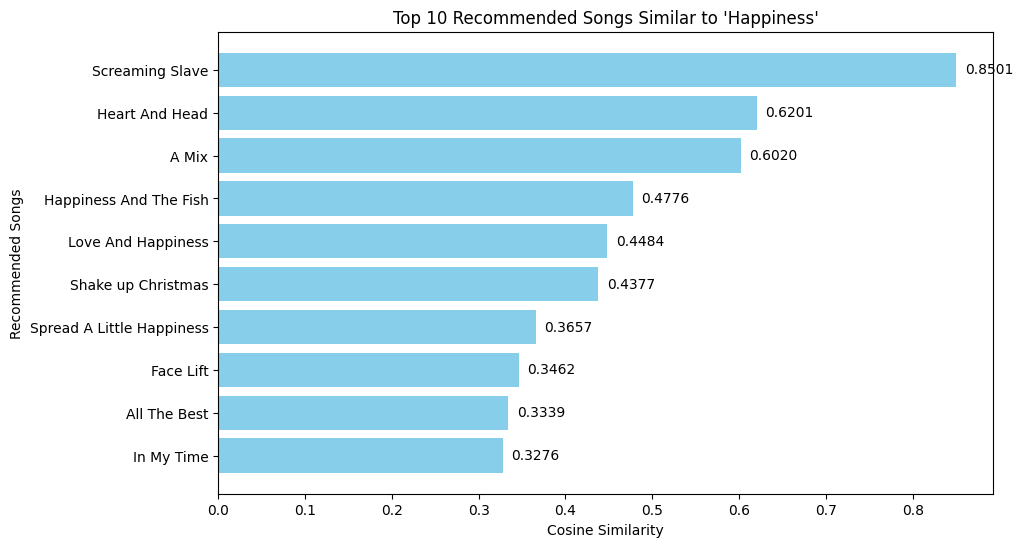

In [ ]:
def measure_recommendations_for_input(song_user_likes, df, cosine_sim, top_k=10):
    if song_user_likes not in df['song'].values:
        print(f"'{song_user_likes}' not found in the dataset.")
        return

    song_index = df[df['song'] == song_user_likes].index[0]

    similarities = cosine_sim[song_index]

    similar_song_indices = np.argsort(similarities)[-top_k-1:-1][::-1]
    recommended_songs = df.iloc[similar_song_indices]['song'].values
    recommended_similarities = similarities[similar_song_indices]

    print(f"Top {top_k} Recommended Songs for '{song_user_likes}':")
    for i, (song, score) in enumerate(zip(recommended_songs, recommended_similarities), 1):
        print(f"{i}. {song} (Cosine Similarity: {score:.4f})")

    plt.figure(figsize=(10, 6))
    bars = plt.barh(recommended_songs, recommended_similarities, color="skyblue")
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Recommended Songs")
    plt.title(f"Top {top_k} Recommended Songs Similar to '{song_user_likes}'")
    plt.gca().invert_yaxis()

    for bar, score in zip(bars, recommended_similarities):
        plt.text(
            bar.get_width() + 0.01,
            bar.get_y() + bar.get_height() / 2,
            f"{score:.4f}",
            va="center",
            ha="left",
            fontsize=10,
            color="black"
        )

    plt.show()

measure_recommendations_for_input("Happiness", df, cosine_sim, top_k=10)

Mean Cosine Similarity: 0.4728
Standard Deviation of Similarity Scores: 0.0422


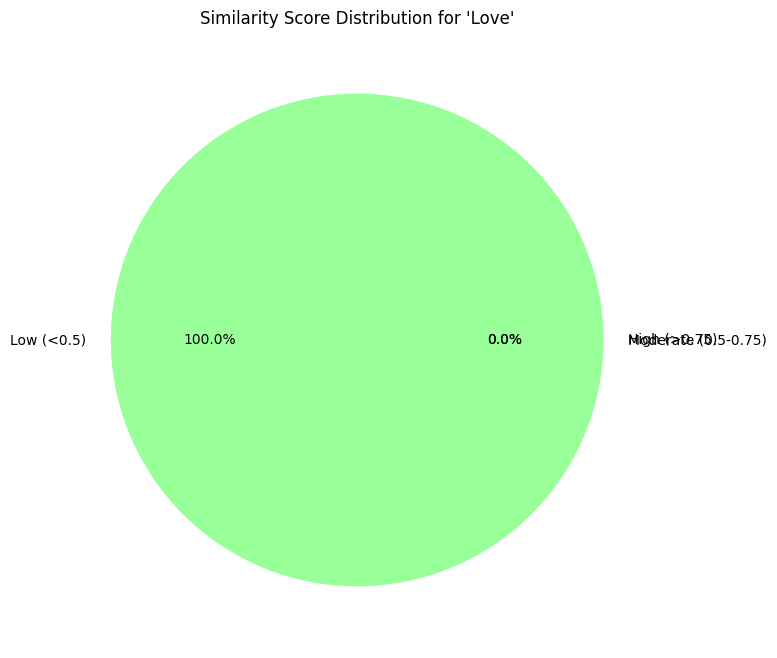

In [12]:
from sklearn.metrics import mean_squared_error

# Evaluate Recommendations
def evaluate_recommendations(df, cosine_sim, top_k=5):
    mean_sims = []
    std_devs = []

    for idx in range(len(df)):
        similarities = cosine_sim[idx]
        similar_song_indices = np.argsort(similarities)[-top_k-1:-1][::-1]
        recommended_similarities = similarities[similar_song_indices]

        mean_sims.append(np.mean(recommended_similarities))
        std_devs.append(np.std(recommended_similarities))

    print(f"Mean Cosine Similarity: {np.mean(mean_sims):.4f}")
    print(f"Standard Deviation of Similarity Scores: {np.mean(std_devs):.4f}")

evaluate_recommendations(df, cosine_sim, top_k=5)

# Visualization: Pie Chart of Similarity Distribution
def plot_similarity_pie(song_user_likes, df, cosine_sim):
    if song_user_likes not in df['song'].values:
        print(f"'{song_user_likes}' not found in the dataset.")
        return

    song_index = df[df['song'] == song_user_likes].index[0]
    similarities = cosine_sim[song_index]

    labels = ['High (>0.75)', 'Moderate (0.5-0.75)', 'Low (<0.5)']
    counts = [
        np.sum(similarities > 0.75),
        np.sum((similarities > 0.5) & (similarities <= 0.75)),
        np.sum(similarities <= 0.5)
    ]

    plt.figure(figsize=(8, 8))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', colors=["#ff9999","#66b3ff","#99ff99"])
    plt.title(f"Similarity Score Distribution for '{song_user_likes}'")
    plt.show()

plot_similarity_pie("Love", df, cosine_sim)